# The Transportation Problem

**Key Ideas**
- supply point and supply constraint
- demand point and demand constraint
- balanced transportation problem
- bipartite graph
- integrality properties
- sensitivity analysis

**Reading Assignment**
- Read the first part of Handout 7 on the transportation problem (first 4 pages)

**Brief description:** We will explore examples of the transportation problem including some unexpected ones. We will also learn how to use Python and OR-Tools to represent and solve mathematical programming problems.

### Import the following

In [1]:
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from ortools.linear_solver import pywraplp as OR
from IPython.display import Image

### Part 1: The Caterer's Problem

(From Winston, page 390) The Carter Caterer Company must have the following number of clean napkins available
at the beginning of each of the next four days: day 1, 15; day 2, 12; day 3, 18; day 4, 6. After being used, a napkin
can be cleaned by one of two methods: fast service or slow service. Fast service costs 10 cents per napkin, and
a napkin cleaned via fast service is available for use the day after it is last used. Slow service costs 6 cents per
napkin, and these napkins can be reused two days after they are last used. New napkins can be purchased for a
cost of 20 cents per napkin. The catering company currently has no napkins, whatsoever. We wish to meet the
demand for the next four days as cheaply as possible.

The following questions will lead you to formulate this optimization problem as a balanced transportation problem.

**Q1:** First think about the demand points. What do you think is being demanded? What is the demand for each of them? <font color='grey'>(Hint: There are four demand points.) </font>

*Answer:*

**Q2:** Now think about the supply points. One supply point is the store where napkins are purchased. What are all the supply points? What is the supply for each of them? <font color='grey'>(Hint: Napkins used on day $i$ can come from those used on day $i-1$ given fast service or day $i-2$ given slow service.) </font>

*Answer:*

**Q3:** What is the per-unit shipping cost between each supply point and each demand point?

*Answer:*

**Q4:** Create a graphical representation of this input (combine your answers from Q1-Q3), and upload as an image into the next cell by entering the image name if it is in the same folder as this lab. Make sure that it displays properly within the notebook.

In [ ]:
Image("image address")

We came up with the following formulation for the Caterer’s Problem where the demand points are the four days (1, 2, 3, 4) and the supply points are the store ($s$) and the ends of the first three days (1’, 2’, 3’). The supply/demand amounts and costs are summarized in the table below. Did you get a similar formulation?

|         | 1  | 2  | 3  | 4  | supplies |
|---------|----|----|----|----|----------|
| $s$     | 20 | 20 | 20 | 20 | $\infty$ |
| 1'      | -  | 10 | 6  | -  | 15       |
| 2'      | -  | -  | 10 | 6  | 12       |
| 3'      | -  | -  | -  | 10 | 18       |
| demands | 15 | 12 | 18 | 6  |          |

**Q5:** Since we do not usually deal with infinity, what is a large enough value that can be the amount of supply at $s$? <font color='grey'>(Hint: Buy new napkins every day.)</font>

*Answer:*

**Q6:** Is this formulation balanced? If not, how can you convert it into a balanced transportation problem?

*Answer:*

**Q7:** What is the purpose of a dummy demand point in terms of napkins? For instance, what napkins come here, and what happens to them?

*Answer:*

**Q8:** Fill out the missing values (XXX) in the table below. We substituted the dashes with a big enough number like 1000.

|         | 1    | 2    | 3    | 4    | dummy | supplies |
|---------|------|------|------|------|-------|----------|
| $s$     | 20   | 20   | 20   | 20   | XXX   | XXX      |
| 1'      | 1000 | 10   | 6    | 1000 | XXX   | 15       |
| 2'      | 1000 | 1000 | 10   | 6    | XXX   | 12       |
| 3'      | 1000 | 1000 | 1000 | 10   | XXX   | 18       |
| demands | 15   | 12   | 18   | 6    | XXX   |          |

### Part 2: Solving Using a Computer

The next cell contains our model. Later in the course, you will practice writing your own models, but for now, read through the code and run it.
- 'supply' is a dictionary of the form *origin node : supply at node*
- 'demand' is a dictionary of the form *destination node : demand at node*
- 'cost' is a dictionary of the form *(origin node, destination node) : cost to ship on this path*

In [2]:
# a transportation model
def Transp(supply,demand,cost,solver):
    ORIG = list(supply.keys())    # origins
    DEST = list(demand.keys())    # destinations
    ARCS = list(cost.keys())      # arcs
    
    # define model
    m = OR.Solver('transportation', solver)
    
    # parameters
    for i in ORIG:
        m.Add(supply[i] >= 0)
    for i in DEST:
        m.Add(demand[i] >= 0)
    for i,j in ARCS:
        m.Add(cost[i,j] >= 0)
    m.Add(sum(supply[i] for i in ORIG) == sum(demand[j] for j in DEST))
    
    # decision variables
    Trans = {}    # units to be shipped
    for i,j in ARCS:
        Trans[i,j] = m.NumVar(0, m.infinity(), ('(%s, %s)' % (i,j))) 
        
    # objective function
    m.Minimize(sum(cost[i,j]*Trans[i,j] for i,j in ARCS))
        
    # subject to: equals supply
    for i in ORIG:
        m.Add(sum(Trans[i,j] for j in DEST) == supply[i])
        
    # subject to: equals demand
    for j in DEST:
        m.Add(sum(Trans[i,j] for i in ORIG) == demand[j])
    
    m.Solve()
    
    print('Solution:')
    print('Objective value =', m.Objective().Value())
    for i,j in ARCS:
        print(Trans[i,j].name(), ':', Trans[i,j].solution_value())

Here is an example set of data you can solve using the model.

| Steel Mills | Tons Supplied |
|-------------|---------------|
| GARY        | 1400          |
| CLEV        | 2600          |
| PITT        | 2900          |

The steel is sold to car manufacturers.

| Car Manufacturers | Tons Demanded |
|-------------------|---------------|
| FRA               | 900           |
| DET               | 1200          |
| LAN               | 600           |
| WIN               | 400           |
| STL               | 1700          |
| FRE               | 1100          |
| LAF               | 1000          |

This table contains shipping costs per ton:

|     | GARY | CLEV | PITT |
|-----|------|------|------|
| FRA | 39   | 27   | 24   |
| DET | 14   | 9    | 14   |
| LAN | 11   | 12   | 17   |
| WIN | 14   | 9    | 13   |
| STL | 16   | 26   | 28   |
| FRE | 82   | 95   | 99   |
| LAF | 8    | 17   | 20   |

In [3]:
# run me!
ex_supply = {'GARY':1400, 'CLEV':2600, 'PITT':2900}
ex_demand = {'FRA':900, 'DET':1200, 'LAN':600, 'WIN':400, 'STL':1700, 'FRE':1100, 'LAF':1000}
ex_cost = {('GARY','FRA'):39, ('CLEV','FRA'):27, ('PITT','FRA'):24,
           ('GARY','DET'):14, ('CLEV','DET'):9, ('PITT','DET'):14,
           ('GARY','LAN'):11, ('CLEV','LAN'):12, ('PITT','LAN'):17,
           ('GARY','WIN'):14, ('CLEV','WIN'):9, ('PITT','WIN'):13,
           ('GARY','STL'):16, ('CLEV','STL'):26, ('PITT','STL'):28,
           ('GARY','FRE'):82, ('CLEV','FRE'):95, ('PITT','FRE'):99,
           ('GARY','LAF'):8, ('CLEV','LAF'):17, ('PITT','LAF'):20}

Transp(ex_supply,ex_demand,ex_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 196200.0
(GARY, FRA) : 0.0
(CLEV, FRA) : 0.0
(PITT, FRA) : 900.0
(GARY, DET) : 0.0
(CLEV, DET) : 1200.0
(PITT, DET) : 0.0
(GARY, LAN) : 0.0
(CLEV, LAN) : 600.0
(PITT, LAN) : 0.0
(GARY, WIN) : 0.0
(CLEV, WIN) : 400.0
(PITT, WIN) : 0.0
(GARY, STL) : 300.0
(CLEV, STL) : 0.0
(PITT, STL) : 1400.0
(GARY, FRE) : 1100.0
(CLEV, FRE) : 0.0
(PITT, FRE) : 0.0
(GARY, LAF) : 0.0
(CLEV, LAF) : 400.0
(PITT, LAF) : 600.0


**Q9:** Format the data for the Caterer's Problem similar to above so that it can be solved by our model. (Note: Strings need to be in quotes.)

In [4]:
c_supply = {'s':51, "1'":15, "2'":12, "3'":18}
c_demand = {1:15, 2:12, 3:18, 4:6, 'd':45}
c_cost = {('s',1):20, ('s',2):20, ('s',3):20, ('s',4):20, ('s','d'):0,
          ("1'",1):1000, ("1'",2):10, ("1'",3):6, ("1'",4):1000, ("1'",'d'):0,
          ("2'",1):1000, ("2'",2):1000, ("2'",3):10, ("2'",4):6, ("2'",'d'):0,
          ("3'",1):1000, ("3'",2):1000, ("3'",3):1000, ("3'",4):10, ("3'",'d'):0}

Transp(c_supply,c_demand,c_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 666.0
(s, 1) : 15.0
(s, 2) : 3.0
(s, 3) : 0.0
(s, 4) : 0.0
(s, d) : 33.0
(1', 1) : 0.0
(1', 2) : 9.0
(1', 3) : 6.0
(1', 4) : 0.0
(1', d) : 0.0
(2', 1) : 0.0
(2', 2) : 0.0
(2', 3) : 12.0
(2', 4) : 0.0
(2', d) : 0.0
(3', 1) : 0.0
(3', 2) : 0.0
(3', 3) : 0.0
(3', 4) : 6.0
(3', d) : 12.0


**Q10:** Reinterpret the solution in words including how we get napkins for each day.

*Answer:*

### Part 3: Exploring the Optimal Solution

We will start by solving a new problem. An oil company imports crude from three sources and refines it at five refineries. Sources 1, 2, 3 can ship 20, 50, 20 units of crude respectively each week. Refineries 1 to 5 need 10, 24, 6, 20, 30 units of crude respectively each week. The table below contains the unit shipping costs from the sources to the refineries. The entry in the $i$th row and $j$th column gives the cost to ship from source $i$ to refinery $j$.

|    |    |    |    |    |
|----|----|----|----|----|
| 30 | 30 | 10 | 27 | 15 |
| 15 | 15 | 8  | 13 | 5  |
| 25 | 21 | 5  | 15 | 21 |

**Q11:** Solve the oil problem using our Python model.

In [5]:
o_supply = {'S1':20, 'S2':50, 'S3':20}
o_demand = {'R1':10, 'R2':24, 'R3':6, 'R4':20, 'R5':30}
o_cost = {('S1','R1'):30, ('S1','R2'):30, ('S1','R3'):10, ('S1','R4'):27, ('S1','R5'):15,
          ('S2','R1'):15, ('S2','R2'):15, ('S2','R3'):8, ('S2','R4'):13, ('S2','R5'):5,
          ('S3','R1'):25, ('S3','R2'):21, ('S3','R3'):5, ('S3','R4'):15, ('S3','R5'):21}

Transp(o_supply,o_demand,o_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

Solution:
Objective value = 1160.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 6.000000000000003
(S1, R4) : 0.0
(S1, R5) : 13.999999999999998
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.0
(S2, R5) : 16.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.0
(S3, R4) : 20.000000000000004
(S3, R5) : 0.0


Now consider the values $u(1) = 25$, $u(2) = 15$, $u(3) = 17$, $v(1) = 0$, $v(2) = 0$, $v(3) = -15$, $v(4) = -2$, and $v(5) = -10$.  

**Q12:** Write down the modified cost matrix, where as shown in class, we subtract $u(i)$ from all the entries in row $i$, and similarly we subtract $v(j)$ from each entry of column $j$. Argue why the solution computed above is indeed optimal for the original input.

*Answer:*

|    |    |    |    |    |
|----|----|----|----|----|
| 30 | 30 | 10 | 27 | 15 |
| 15 | 15 | 8  | 13 | 5  |
| 25 | 21 | 5  | 15 | 21 |

Now suppose that we anticipate the cost of shipping from source 1 to refinery 1 (currently equal 30) to go down. Observe that in the current optimal solution, we do not ship anything from source 1 to refinery 1. An interesting question is "By how much should $c(1,1)$ decrease before we will consider shipping some positive amount along that path?"

**Q13:** Try the following values for $c(1,1)$: 28, 26, 25, 24. (Note: Use the same names from Q11 for the nodes.) Record the optimal solutions in the table. Also include the value $\overline{c}(1,1)$ from the matrix of modified costs (recall $\overline{c}(1,1) = c(1,1) - u(1) - v(1)$). What can you conclude?

In [ ]:
o_cost['S1','R1'] = 28
Transp(o_supply,o_demand,o_cost,OR.Solver.GLOP_LINEAR_PROGRAMMING)

*Answer:*

|                     | 28 | 26 | 25 | 24 |
|---------------------|----|----|----|----|
| x(1,1)              |    |    |    |    |
|                     |    |    |    |    |
|                     |    |    |    |    |
|                     |    |    |    |    |
|                     |    |    |    |    |
|                     |    |    |    |    |
|                     |    |    |    |    |
| $\overline{c}$(1,1) |    |    |    |    |

Now consider the original model with $c(1,1) = 30$. 

**Q14:** Could you use the modified cost matrix to answer the same kind of question raised above for changes in any $c(i,j)$ parameter? Try to use your observations to figure out by how much the value of $c(2,3)$ needs to be reduced so that we will consider shipping from source 2 to refinery 3. Check your answer using our Python model.

*Answer:*

Once again start with the original model and data. Because of a trade agreement, the amount that is shipped from source 2 to refinery 5 cannot exceed the amount that is shipped to refinery 5 from sources 1 and 3 combined by more than 1. Add a constraint like the following to the model function to represent this trade agreement: `m.Add(Trans['S2','R5'] <= Trans['S1','R5'] + Trans['S3','R5'] + 1)`

**Q15:** Rerun the model cell and re-solve to find the new optimal solution and objective value.

*Answer:*

|          | Refinery 1 | 2 | 3 | 4 | 5 |
|----------|------------|---|---|---|---|
| Source 1 |            |   |   |   |   |
| 2        |            |   |   |   |   |
| 3        |            |   |   |   |   |

**Q16:** What is different from your previous solutions? What property does not hold anymore now that we have added the trade agreement constraint?

*Answer:*

Since the shipping is done in barrels, we want the optimal solution to have only integer flow values. Change the declaration of the *Trans* variables by replacing `m.NumVar` with `m.IntVar`. GLOP does not know how to deal with integer variables, so the solver should also change to `OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING`.

**Q17:** Re-solve.

*Answer:*

|          | Refinery 1 | 2 | 3 | 4 | 5 |
|----------|------------|---|---|---|---|
| Source 1 |            |   |   |   |   |
| 2        |            |   |   |   |   |
| 3        |            |   |   |   |   |

**Q18:** Note that the optimal objective function value is higher than it was before we added the integrality constraint. Can you explain why it could never be lower than it was before we added the constraint that all *Trans* values had to be integer?

*Answer:*

### Part 4: Application for First-Year Writing Seminars?

**Introduction:** If you recall pre-enroll, there was a separate ballot you completed by listing your top 5 picks for FWS that semester. You were then later notified which class you got placed into, probably hoping it was your first choice. By now, this should not seem like magic; problems like these often enlist help from Operations Research especially as the scale increases. Disclaimer: the following model is not actually used by Cornell.

**Questions:**
- How can FWS sections be assigned so that the most number of students get one of their top 5 picks?
- How can we improve the assignments?

We want to *assign* a class to each student. This sounds like an assignment problem, which is a special case of the *transportation problem*.  

**Mini Example 1**  
The following table gives an instance with 7 students (1-7) and 4 classes (A-D). Each class has a capacity of 2 students. 

| Student | First | Second |
|:-------:|:-----:|:------:|
|    1    |   A   |    B   |
|    2    |   D   |    C   |
|    3    |   A   |    C   |
|    4    |   B   |    D   |
|    5    |   C   |    B   |
|    6    |   A   |    B   |
|    7    |   B   |    A   |

**Q:** What are the supply nodes?  
**A:** <font color='blue'>Students</font>  

**Q:** What are the supply values of the supply nodes? <font color='grey'>(Hint: How many units can be transferred?)</font>  
**A:** <font color='blue'>1</font>  

**Q:** What are the demand nodes?  
**A:** <font color='blue'>Classes</font>  

**Q:** What are the demand values of the demand nodes? <font color='grey'>(Hint: How many units can be received?)</font>  
**A:** <font color='blue'>Capacity which in this case is 2</font>  

**Q:** What does a directed edge from a supply node to a demand node mean?  
**A:** <font color='blue'>The student is assigned to that class</font>  

**Q:** What are the edge costs?  
**A:** <font color='blue'>1 for student to first and 2 for student to second (minimize cost)</font>

Visualize your graph by adding the missing data into the dictionaries S, D, and C in a similar format as before. If you use letters as node names, make sure to put quotes around them.

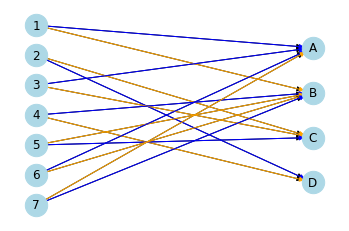

In [6]:
from fws import ex1

S = {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1}
D = {'A':2, 'B':2, 'C':2, 'D':2}
C = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, (4,'B'):1, (4,'D'):2, 
     (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, (7,'B'):1, (7,'A'):2}

ex1(S, D, C)

To complete the simple model, we need to answer one more question.  

**Q:** The total demand is 8, but the current total supply is only 7. How can we make sure that demand is satisfied for there to be a feasible solution?  
**A:** <font color='blue'>Add a dummy node and edges going from it to every class node with cost 3</font>  


Update the dictionaries below as see fit.

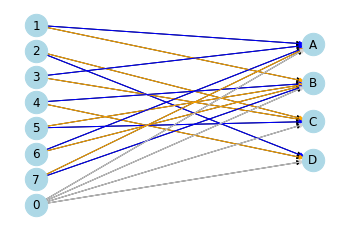

In [7]:
S = {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 0:1}
C = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, (4,'B'):1, (4,'D'):2, 
     (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, (7,'B'):1, (7,'A'):2, (0,'A'):3, (0,'B'):3, (0,'C'):3, (0,'D'):3}

ex1(S, D, C)

Now we can use our computers to solve. The previous *Transp* model has been slightly modified into *Assign* for convenience.

In [8]:
# a modified transportation model for fws
def Assign(supply,demand,cost,dcost,solver):
    ORIG = list(supply.keys())    # origins
    DEST = list(demand.keys())    # destinations
    for x in DEST:
        cost.update({(0,str(x)):dcost})
    ARCS = list(cost.keys())      # arcs
    
    # define model
    m = OR.Solver('assignFWS', solver)
    
    # parameters
    for i in ORIG:
        m.Add(supply[i] >= 0)
    for i in DEST:
        m.Add(demand[i] >= 0)
    for i,j in ARCS:
        m.Add(cost[i,j] >= 0)
    
    # decision variables
    Trans = {}    # units to be shipped
    for i,j in ARCS:
        Trans[i,j] = m.IntVar(0, m.infinity(), ('(%s, %s)' % (i,j))) 
        
    # objective function
    m.Minimize(sum(cost[i,j]*Trans[i,j] for i,j in ARCS))
        
    # subject to: does not exceed supply
    for k in ORIG:
        m.Add(sum(Trans[i,j] for i,j in ARCS if i==k) <= supply[k])
        
    # subject to: equals demand
    for k in DEST:
        m.Add(sum(Trans[i,j] for i,j in ARCS if j==k) == demand[k])
    
    m.Solve()
    
    print('Solution:')
    print('Objective value =', m.Objective().Value())
    unmatched = []
    for k in ORIG:
        if (sum(Trans[i,j].solution_value() for i,j in ARCS if i==k) == 0) and (k!=0):
            unmatched.append(k)
    print("Unmatched students:", len(unmatched))
    
    matched = {}
    for i,j in ARCS:
        if Trans[i,j].solution_value() == 1:
            if cost[i,j] in matched:
                matched[cost[i,j]] += 1
            else:
                matched.update({cost[i,j] : 1})
    dcost = cost[(0,str(DEST[0]))]
    if dcost in matched.keys():
        del matched[dcost]
    print(matched)
    
    return matched

Main changes include removing the balanced requirement, adding dummy node and edges inside the function, and printing different values at the end.  
**Q:** Explain why or give an example where it might not be necessary for this to be a balanced transportation problem?  
**A:** 

**Q:** What is the solution to Mini Example 1?  
**A:**

In [9]:
sol1 = Assign(S, D, C, 3, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Solution:
Objective value = 11.0
Unmatched students: 0
{1: 6, 2: 1}


**Q:** Why can't all the students be assigned their first choice? Or do you think the answer you got could be better?  
**A:** <font color='blue'>Limited capacity of classes</font> 

**Mini Example 2**  
In this new instance with 8 students (1-8) and 4 classes (A-D), more students prefer A and B than C and D:  

| Student | First | Second |
|:-------:|:-----:|:------:|
|    1    |   A   |    B   |
|    2    |   B   |    A   |
|    3    |   C   |    D   |
|    4    |   A   |    B   |
|    5    |   B   |    A   |
|    6    |   A   |    C   |
|    7    |   C   |    D   |
|    8    |   A   |    D   |

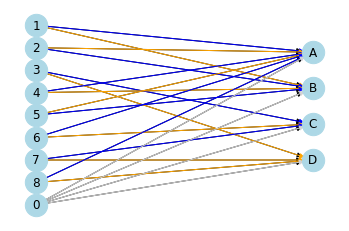

In [10]:
from fws import ex2

S2 = {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 0:len(D)*2}
D2 = D
C2 = {(1,'A'):1, (1,'B'):2, (2,'B'):1, (2,'A'):2, (3,'C'):1, (3,'D'):2, (4,'A'):1, (4,'B'):2, 
      (5,'B'):1, (5,'A'):2, (6,'A'):1, (6,'C'):2, (7,'C'):1, (7,'D'):2, (8,'A'):1, (8,'D'):2,
      (0,'A'):3, (0,'B'):3, (0,'C'):3, (0,'D'):3}

ex2(S2, D2, C2)

**Q:** What is the solution to Mini Example 2?  
**A:**

In [11]:
sol2 = Assign(S2, D2, C2, 2.5, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Solution:
Objective value = 10.5
Unmatched students: 1
{1: 6, 2: 1}


**Q:** Why can't all the students be assigned one of their top 2 choices? Or do you think the answer you got could be better?  
**A:** <font color='blue'>Can find a 0 unmatched assignment</font>  

**Q:** Re-solve using 3 as the cost.  
**A:**

In [12]:
sol3 = Assign(S2, D2, C2, 3, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Solution:
Objective value = 11.0
Unmatched students: 0
{1: 5, 2: 3}


**Q:** 2.5 and 3 are both greater than 1 and 2 and prioritized last. What then is causing the different solutions?  
**A:** <font color='blue'>The combined cost of a first pick edge and a dummy edge versus two second pick edges: $1+2.5 < 2+2$ while $1+3 = 2+2$ </font>  

When solving the actual data, you will see that other subtle reasons might lead to unmatched students.

### Part 5: Actual FWS Data

There are 2886 students and 183 class sections. Assume each class can have at most 16 students. As we already know, each student picks their top 5 classes.

In [13]:
# read in the dataset
data = pd.read_csv('Fall2009Ballots.csv')
data.head()    # preview

,STUDENTS,1,2,3,4,5
0,1,145,142,125,143,80
1,2,72,12,149,171,8
2,3,79,87,37,120,97
3,4,104,101,103,100,99
4,5,26,154,149,101,28


There are 6 columns with the first being student # and the other 5 being first, second, third, fourth, and fifth choice. Each row is a student, and class # indicates the class picked as the choice belonging to the column.  

The dataset has been transformed behind the scenes from what you see above into the correct formats for the inputs. Nothing has changed about the model except the edge costs are equal to the choice rank (1-5) and the edges from the dummy node have a cost of 6.

**Q:** Solve.

In [14]:
from fws import inputData
d_supply,d_demand,d_cost = inputData('Fall2009Ballots.csv')

data_sol = Assign(d_supply, d_demand, d_cost, 6, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Solution:
Objective value = 5500.0
Unmatched students: 79
{1: 1623, 4: 152, 2: 643, 3: 344, 5: 45}


We got an answer! Unfortunately, there are 79 students who did not get any of their top 5 picks. Let's try to make our model better, so that no students are unmatched.  

The objective function is actually a weighted function. The coefficients, which in this case are the costs, dictate how much you want the solver to select the corresponding edges. An edge with a small cost has a higher likelihood (weight) of being in the solution while an edge with a large cost will potentially be avoided. This being said, we can try setting the cost of edges from the dummy node to an arbitrarily large number like 100,000. This should create greater incentive to fill classes with actual students than our fake filler 'students' as we witnessed in the second small example.

**Q:** Solve.

In [15]:
data_sol2 = Assign(d_supply, d_demand, d_cost, 100000, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Solution:
Objective value = 4205307.0
Unmatched students: 0
{1: 1524, 4: 210, 2: 681, 3: 387, 5: 84}


Yay! We just improved our model. As a bonus, we can look at the distribution of preferences received by students in the form of a histogram and see how our solution did in percentages.

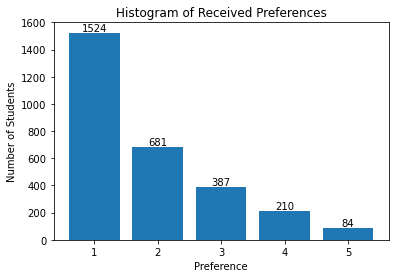

1 : 52.81 %
4 : 7.28 %
2 : 23.6 %
3 : 13.41 %
5 : 2.91 %


In [16]:
from fws import Histo
Histo(data_sol2, 15)

for pref in data_sol2.keys():
    print(pref, ":", round(100*data_sol2[pref]/2886, 2), "%")

### Part 6: Challenges

We do not want to waste time trying different cost combinations if there is no solution where every student gets one of their top 5 picks. How can we check whether there exists a feasible solution with 0 unmatched students?

**Q:** What is the cost of edges representing students' preferences?  
**A:** <font color='blue'>0</font>  

**Q:** What is the cost of dummy edges?  
**A:** <font color='blue'>1</font>  

**Q:** What is the desired solution?  
**A:** <font color='blue'>Zero cost assignment</font>  

-- OR --  
**Q:** Describe another way that might use a different model.  
**A:** <font color='blue'>e.g. max flow</font>  

There are many ways to improve a model even if the type of problem does not change. Previously, we decided it was important for an assignment to guarantee that everyone got at least one of their top 5 picks. How can you make a better yet model? <font color='grey'>(Your answer will depend on what you think makes the best assignment. Some things to consider: reducing the number of students getting their lesser-preferred choices, adding a lower bound on class size, choosing for two students to both have their 3rd choice instead of one 1st and the other 5th, using recursion...)</font>

**A:**